In [1]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [3]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [16]:
dont_use = [
    'card_id', 
    'first_active_month',
    'second_active_date',
    'diff_first_and_second',
    'target','outliers', 
    'category_1_Y_std', 
    'hist_purchase_date_max',
    'hist_purchase_date_min',
    'hist_category_2_mean_mean',
    'hist_category_3_mean_mean'
]

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]
target_sign_p = df_train['target'].apply(lambda x:1 if x>=0 else 0)

In [11]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [12]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [13]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'hist_card_id_size',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapsed',
 'most_recent_purchases_range_null_latest_trs',
 'most_recent_sales_range_null_latest_trs',
 'new_hist_purchase_date_min',
 'numerical_1_null_latest_trs']

In [14]:
len(df_train_columns)

270

In [19]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_sign_p.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_sign_p.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_sign_p, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.679549	valid_1's auc: 0.67718
[200]	training's auc: 0.683131	valid_1's auc: 0.679991
[300]	training's auc: 0.686714	valid_1's auc: 0.682795
[400]	training's auc: 0.689931	valid_1's auc: 0.685061
[500]	training's auc: 0.692923	valid_1's auc: 0.686976
[600]	training's auc: 0.695666	valid_1's auc: 0.688578
[700]	training's auc: 0.698257	valid_1's auc: 0.69004
[800]	training's auc: 0.700638	valid_1's auc: 0.69125
[900]	training's auc: 0.702834	valid_1's auc: 0.692166
[1000]	training's auc: 0.704978	valid_1's auc: 0.693038
[1100]	training's auc: 0.706942	valid_1's auc: 0.693743
[1200]	training's auc: 0.70879	valid_1's auc: 0.694309
[1300]	training's auc: 0.710574	valid_1's auc: 0.694833
[1400]	training's auc: 0.71222	valid_1's auc: 0.695216
[1500]	training's auc: 0.713835	valid_1's auc: 0.695553
[1600]	training's auc: 0.715357	valid_1's auc: 0.695858
[1700]	training's auc: 0.716844	valid_1's auc: 0

[4000]	training's auc: 0.745192	valid_1's auc: 0.697894
[4100]	training's auc: 0.746338	valid_1's auc: 0.69789
[4200]	training's auc: 0.747467	valid_1's auc: 0.697871
[4300]	training's auc: 0.7486	valid_1's auc: 0.697887
[4400]	training's auc: 0.749735	valid_1's auc: 0.697904
[4500]	training's auc: 0.750847	valid_1's auc: 0.69791
[4600]	training's auc: 0.751951	valid_1's auc: 0.697924
[4700]	training's auc: 0.753047	valid_1's auc: 0.697945
[4800]	training's auc: 0.754153	valid_1's auc: 0.697956
[4900]	training's auc: 0.75524	valid_1's auc: 0.697978
[5000]	training's auc: 0.756317	valid_1's auc: 0.697972
[5100]	training's auc: 0.75741	valid_1's auc: 0.69799
[5200]	training's auc: 0.758467	valid_1's auc: 0.697995
[5300]	training's auc: 0.759544	valid_1's auc: 0.697977
[5400]	training's auc: 0.760616	valid_1's auc: 0.697966
[5500]	training's auc: 0.761679	valid_1's auc: 0.697973
Early stopping, best iteration is:
[5131]	training's auc: 0.757738	valid_1's auc: 0.698008
fold 3
Training unti

0.6957215079145606

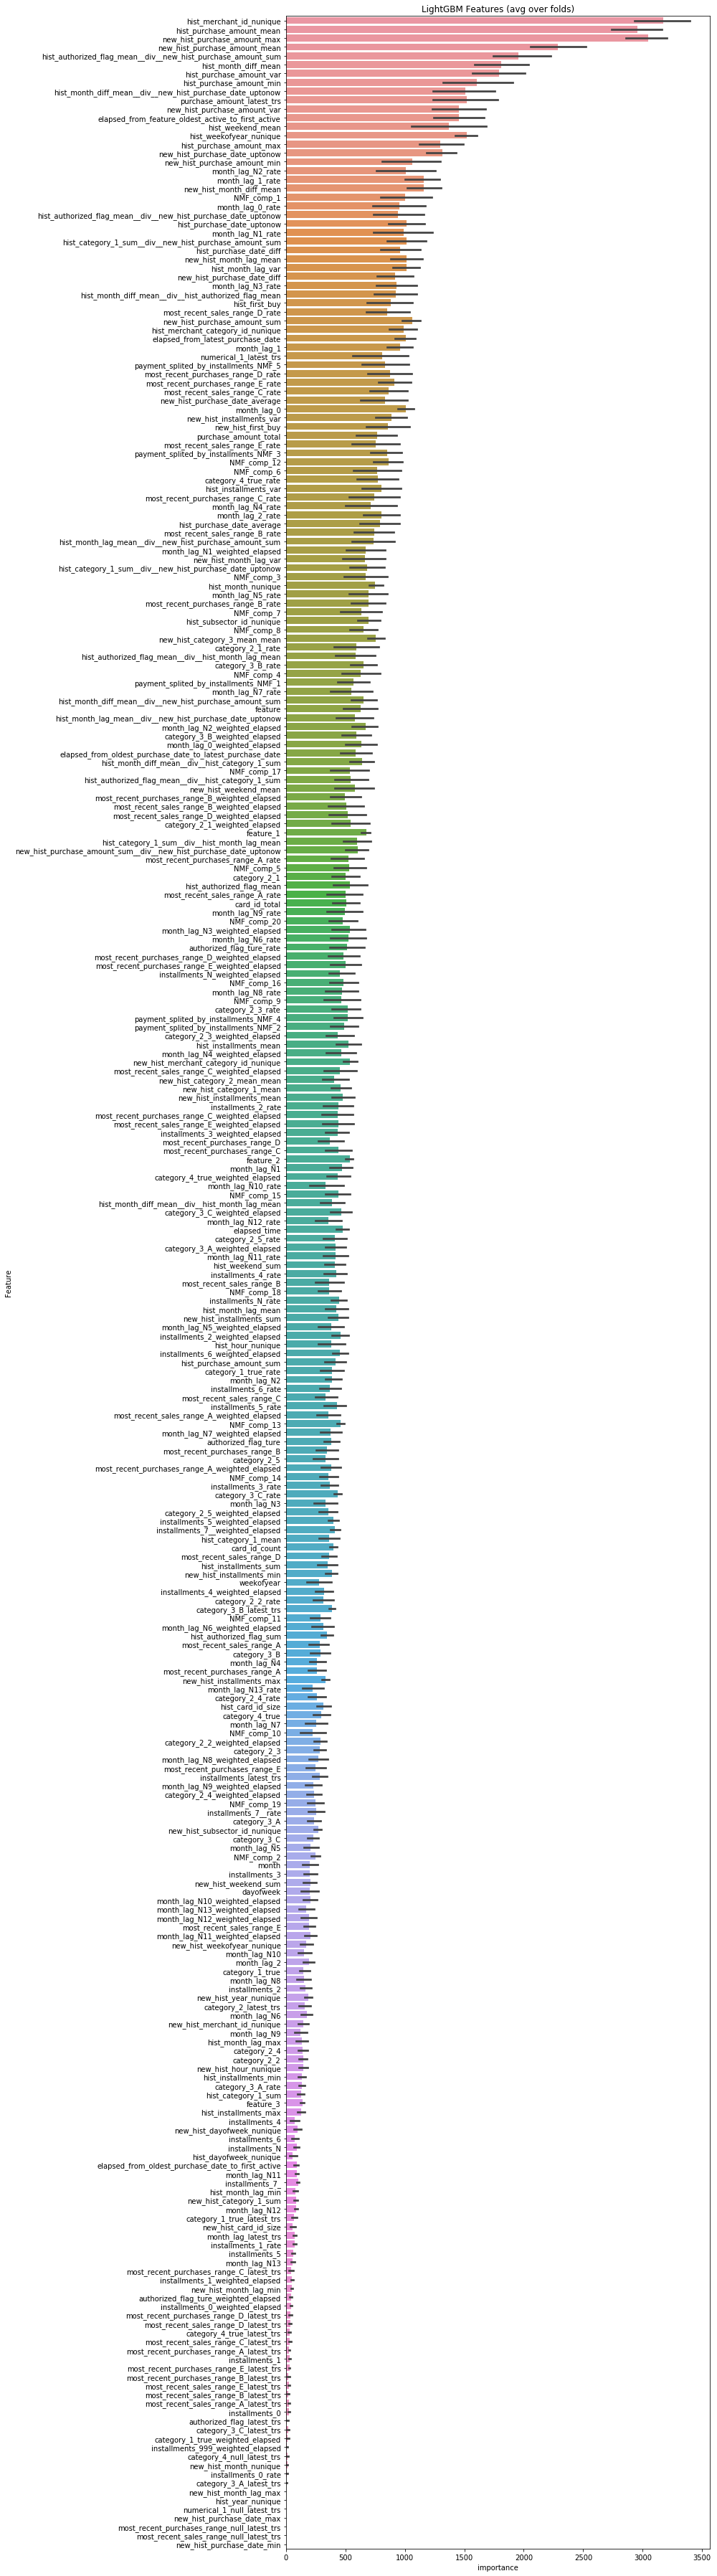

In [20]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [21]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_sign_p.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_sign_p.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_sign_p, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.679471	valid_1's auc: 0.677054
[200]	training's auc: 0.683053	valid_1's auc: 0.679977
[300]	training's auc: 0.686702	valid_1's auc: 0.682812
[400]	training's auc: 0.689932	valid_1's auc: 0.685153
[500]	training's auc: 0.692918	valid_1's auc: 0.687034
[600]	training's auc: 0.695643	valid_1's auc: 0.688629
[700]	training's auc: 0.698245	valid_1's auc: 0.690121
[800]	training's auc: 0.700617	valid_1's auc: 0.69133
[900]	training's auc: 0.702815	valid_1's auc: 0.692285
[1000]	training's auc: 0.704948	valid_1's auc: 0.693096
[1100]	training's auc: 0.706907	valid_1's auc: 0.693779
[1200]	training's auc: 0.708778	valid_1's auc: 0.694369
[1300]	training's auc: 0.710531	valid_1's auc: 0.694886
[1400]	training's auc: 0.712179	valid_1's auc: 0.695295
[1500]	training's auc: 0.713786	valid_1's auc: 0.695638
[1600]	training's auc: 0.7153	valid_1's auc: 0.695947
[1700]	training's auc: 0.716807	valid_1's auc:

[2900]	training's auc: 0.732021	valid_1's auc: 0.69762
[3000]	training's auc: 0.733232	valid_1's auc: 0.697674
[3100]	training's auc: 0.734422	valid_1's auc: 0.697718
[3200]	training's auc: 0.735627	valid_1's auc: 0.697787
[3300]	training's auc: 0.736824	valid_1's auc: 0.69783
[3400]	training's auc: 0.737998	valid_1's auc: 0.697834
[3500]	training's auc: 0.739174	valid_1's auc: 0.697874
[3600]	training's auc: 0.740311	valid_1's auc: 0.697881
[3700]	training's auc: 0.741472	valid_1's auc: 0.6979
[3800]	training's auc: 0.74263	valid_1's auc: 0.697912
[3900]	training's auc: 0.743763	valid_1's auc: 0.697921
[4000]	training's auc: 0.744914	valid_1's auc: 0.697976
[4100]	training's auc: 0.746071	valid_1's auc: 0.697994
[4200]	training's auc: 0.747181	valid_1's auc: 0.698017
[4300]	training's auc: 0.748303	valid_1's auc: 0.69803
[4400]	training's auc: 0.749431	valid_1's auc: 0.698062
[4500]	training's auc: 0.750536	valid_1's auc: 0.698101
[4600]	training's auc: 0.751632	valid_1's auc: 0.69812

[4900]	training's auc: 0.755234	valid_1's auc: 0.696197
[5000]	training's auc: 0.756294	valid_1's auc: 0.696186
Early stopping, best iteration is:
[4652]	training's auc: 0.752534	valid_1's auc: 0.696214


0.6959089654565406

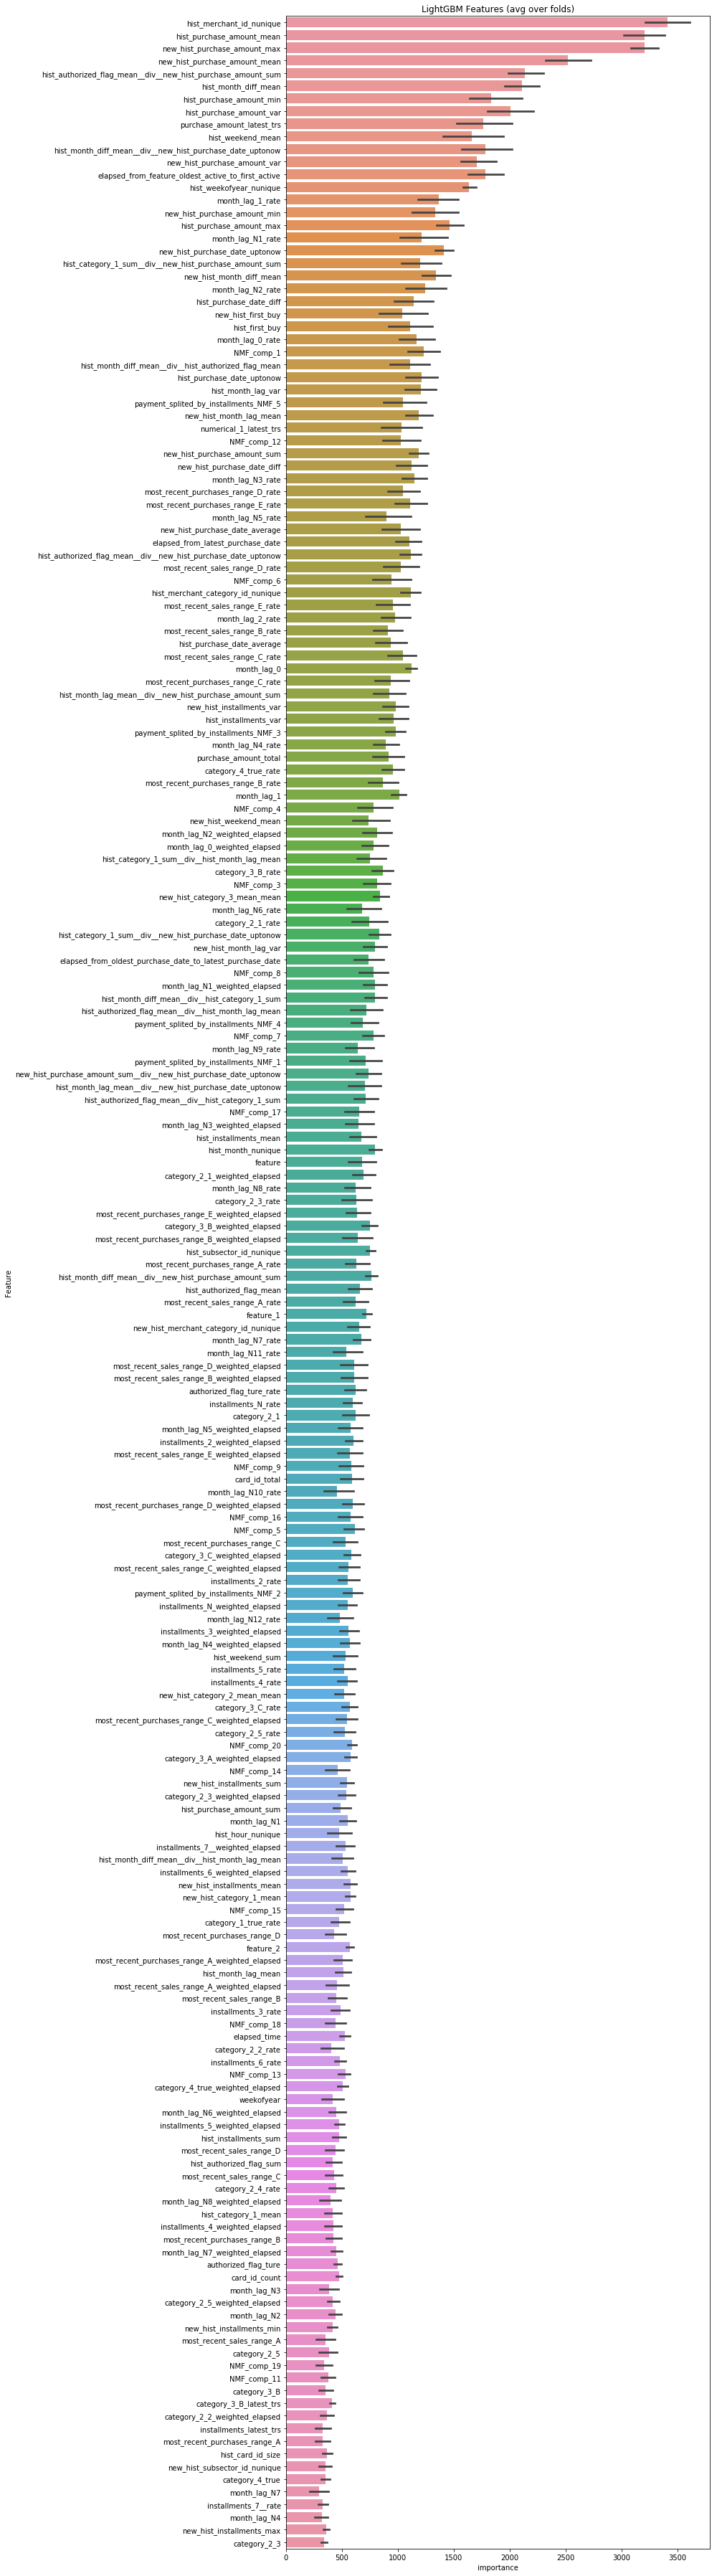

In [22]:
cols2 = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols2)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [27]:
df_sign_train = pd.DataFrame({"card_id":df_train.card_id, "sign_prob":oof})
df_sign_train.to_csv("../input/sign_clf_train_20190120.csv", index=False)

In [28]:
df_predict = pd.DataFrame({"card_id":df_test.card_id, "sign_prob":predictions})
df_predict.to_csv("../input/sign_clf_test_20190120.csv", index=False)